### Programming Assignment 4
##### Submitted By: Saurabh Kumar (SC22B146)
### Implementation of a First Visit Monte Carlo (FVMC) based control algorithm

In this assignment, you have to modify the FVMC based policy evaluation code that was already given in order to make a FVMC based control algorithm  
1. Modify the FVMC code to first estimate state action values rather thanstate values
2. Introduce a policy improvement step
3. Make sure that the policy which is used at every step chooses to explore all actions uniformly at random (with some probability that diminishes with the number of episodes)


In [57]:
import numpy as np
import matplotlib.pyplot as plt

In [58]:
# Startup Code
state_space = np.array([0,1,2,3,4,5])
action_space = np.array([0,1])

reward_matrix = np.zeros((6,2))

reward_matrix[0,0] = 50 # 50 - 2x0
reward_matrix[1,0] = 48 # 50 - 2x1
reward_matrix[2,0] = 42 # 50 - 2x4
reward_matrix[3,0] = 32 # 50 - 2x9
reward_matrix[4,0] = 18 # 50 - 2x16
reward_matrix[5,0] = 0
reward_matrix[0,1] = -100
reward_matrix[1,1] = -100
reward_matrix[2,1] = -100
reward_matrix[3,1] = -100
reward_matrix[4,1] = -100
reward_matrix[5,1] = -100

transition_probability_matrix = np.zeros((2,6,6))
t = np.array([[0.7, 0.3, 0, 0, 0, 0], [0, 0.6, 0.4, 0, 0, 0], [0, 0, 0.5, 0.5, 0, 0], [0, 0, 0, 0.4, 0.6, 0], [0, 0, 0, 0, 0.3, 0.7], [0, 0, 0, 0, 0, 1]])
transition_probability_matrix[0, :, :] = t
t = np.array([[1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]])
transition_probability_matrix[1, :, :] = t

policy_function = np.array([0,0,0,1,0,1])

class MachineRepair_Environment:
    def __init__(self, transition_probability_matrix, reward_matrix, initial_state):
        self.transition_probability_matrix = transition_probability_matrix
        self.reward_matrix = reward_matrix
        self.current_state = initial_state
    
    def get_current_state(self):
        return self.current_state
        
    def run_one_step(self, action):
        transition_probability = transition_probability_matrix[action, self.current_state, :]
        # obtain the reward
        reward = reward_matrix[self.current_state, action]
        # update the state
        next_state = np.random.choice(state_space, p = transition_probability)
        self.current_state = next_state
        return [next_state, reward]

In [59]:
# First Visit Monte Carlo (FVMC)
num_episodes = 1000
horizon = 100
discount_factor = 0.8

# Initialize Q(s,a) estimates and visit counts for state-action pairs
Q_estimate = np.zeros([len(state_space), len(action_space)])
visit_count = np.zeros([len(state_space), len(action_space)])

# Initialize policy with some random policy
policy_function = np.zeros(len(state_space), dtype=int)

for e in range(num_episodes):
    # Decaying exploration rate
    epsilon = 1.0 / (1.0 + e) 
    
    # Start with initial state
    initial_state = 0
    environment = MachineRepair_Environment(transition_probability_matrix, reward_matrix, initial_state)
    
    state_sequence = []
    action_sequence = []
    reward_sequence = []

    # Generate episode following epsilon-greedy policy
    for t in range(horizon):
        state = environment.get_current_state()
        state_sequence.append(state)
        
        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            # Explore: choose random action
            action = np.random.choice(action_space)
        else:
            # Exploit: choose greedy action based on current policy
            action = policy_function[state]
        
        action_sequence.append(action)
        [next_state, reward] = environment.run_one_step(action)
        reward_sequence.append(reward)
    
    # First-visit MC update for state-action pairs
    visited_state_action_pairs = set()
    
    for t in range(len(state_sequence)):
        state = state_sequence[t]
        action = action_sequence[t]
        state_action_pair = (state, action)
        
        # Check if this is the first visit to this state-action pair
        if state_action_pair not in visited_state_action_pairs:
            visited_state_action_pairs.add(state_action_pair)
            
            # Calculate return from this point onwards
            G = 0
            for k in range(t, len(reward_sequence)):
                G += reward_sequence[k] * (discount_factor ** (k - t))
            
            # Update visit count
            visit_count[state, action] += 1.0
            
            # Incremental mean update for Q(s,a)
            Q_estimate[state, action] += (G - Q_estimate[state, action]) / visit_count[state, action]
    
    # Policy Improvement: Update policy to be greedy with respect to Q
    for s in state_space:
        policy_function[s] = np.argmax(Q_estimate[s, :])

# Print results
print("Final Q-values (State-Action Values):")
print(Q_estimate)
print("\nFinal Policy:")
print(policy_function)
print("\nVisit counts:")
print(visit_count)

Final Q-values (State-Action Values):
[[207.47440187  44.57844413]
 [173.48266607  47.0071058 ]
 [131.60137896  53.48832543]
 [ 93.41272151  60.13969152]
 [ 38.50392033  65.97403942]
 [ -5.7152603   28.12364948]]

Final Policy:
[0 0 0 0 1 1]

Visit counts:
[[1000.   83.]
 [1000.   58.]
 [1000.   57.]
 [ 998.   37.]
 [  26.  992.]
 [   6.   22.]]


### Comparison of FVMC and EVMC based control algorithms

1. In this section, we will compare the "learning performance" of FVMC and EVMC algorithms.
2. Consider the "Forest managment" problem from our previous assignment
3. Implement a class to model the Forest Management MDP - this should especially have a function that simulates how the forest's state evolves from one time step to the next under the influence of an action (either cut or wait). The class should be written in a way similar to how the "Machine repair" example was done in the code discussed in class.
4. We will apply both FVMC and EVMC based control algorithms for this Forest management problem.
5. For both algorithms, for each episode keep track of the total discounted reward from time 0. Then we have GFVMC[e] and GEVMC[e] where e is the episode index. Plot and compare GFVMC[e] and GEVMC[e] as a function of e.

In [60]:
import mdptoolbox.example

S = 10 # max age
p = 0.1 # probability of fire
gamma = 0.9 # discount factor

state_space = [s for s in range(S)]
action_space = np.array([0, 1])

# MDP
transition_probability_matrix, reward_matrix = mdptoolbox.example.forest(S, r1=4, r2=2, p=p)

# Environment
class ForestManagement_Environment:
    def __init__(self, transition_probability_matrix, reward_matrix, initial_state):
        self.transition_probability_matrix = transition_probability_matrix
        self.reward_matrix = reward_matrix
        self.current_state = initial_state
    
    def get_current_state(self):
        return self.current_state
    
    def reset(self, initial_state):
        self.current_state = initial_state
        
    def run_one_step(self, action):
        transition_probability = self.transition_probability_matrix[action, self.current_state, :]
        reward = self.reward_matrix[self.current_state, action]
        next_state = np.random.choice(state_space, p=transition_probability)
        self.current_state = next_state
        return [next_state, reward]

In [61]:
# First Visit Monte Carlo Control
def first_visit_mc_control(num_episodes, horizon, discount_factor, environment, state_space, action_space):
    Q_estimate = np.zeros([len(state_space), len(action_space)])
    visit_count = np.zeros([len(state_space), len(action_space)])
    policy_function = np.zeros(len(state_space), dtype=int)
    
    # Total return per episode
    episode_returns = []
    
    for e in range(num_episodes):
        epsilon = 1.0 / (1.0 + e)  # Decaying exploration
        environment.reset(0)  # Start from state 0
        
        state_sequence = []
        action_sequence = []
        reward_sequence = []
        
        # Generate episode
        for t in range(horizon):
            state = environment.get_current_state()
            state_sequence.append(state)
            
            # Epsilon-greedy action selection
            if np.random.random() < epsilon:
                action = np.random.choice(action_space)
            else:
                action = policy_function[state]
            
            action_sequence.append(action)
            [next_state, reward] = environment.run_one_step(action)
            reward_sequence.append(reward)
        
        # Calculate total discounted return from time 0
        G_total = sum(reward_sequence[k] * (discount_factor ** k) for k in range(len(reward_sequence)))
        episode_returns.append(G_total)
        
        # First-visit MC update
        visited_state_action_pairs = set()
        
        for t in range(len(state_sequence)):
            state = state_sequence[t]
            action = action_sequence[t]
            state_action_pair = (state, action)
            
            if state_action_pair not in visited_state_action_pairs:
                visited_state_action_pairs.add(state_action_pair)
                
                # Calculate return from this point
                G = sum(reward_sequence[k] * (discount_factor ** (k - t)) 
                       for k in range(t, len(reward_sequence)))
                
                visit_count[state, action] += 1.0
                Q_estimate[state, action] += (G - Q_estimate[state, action]) / visit_count[state, action]
        
        # Policy improvement
        for s in state_space:
            policy_function[s] = np.argmax(Q_estimate[s, :])
    
    return Q_estimate, policy_function, episode_returns, visit_count

# Every Visit Monte Carlo Control
def every_visit_mc_control(num_episodes, horizon, discount_factor, environment, state_space, action_space):
    Q_estimate = np.zeros([len(state_space), len(action_space)])
    visit_count = np.zeros([len(state_space), len(action_space)])
    policy_function = np.zeros(len(state_space), dtype=int)
    
    # Total return per episode
    episode_returns = []
    
    for e in range(num_episodes):
        epsilon = 1.0 / (1.0 + e)  # Decaying exploration
        environment.reset(0)  # Start from state 0
        
        state_sequence = []
        action_sequence = []
        reward_sequence = []
        
        # Generate episode
        for t in range(horizon):
            state = environment.get_current_state()
            state_sequence.append(state)
            
            # Epsilon-greedy action selection
            if np.random.random() < epsilon:
                action = np.random.choice(action_space)
            else:
                action = policy_function[state]
            
            action_sequence.append(action)
            [next_state, reward] = environment.run_one_step(action)
            reward_sequence.append(reward)
        
        # Calculate total discounted return from time 0
        G_total = sum(reward_sequence[k] * (discount_factor ** k) for k in range(len(reward_sequence)))
        episode_returns.append(G_total)
        
        # Every-visit MC update (no visited set check)
        for t in range(len(state_sequence)):
            state = state_sequence[t]
            action = action_sequence[t]
            
            # Calculate return from this point
            G = sum(reward_sequence[k] * (discount_factor ** (k - t)) 
                   for k in range(t, len(reward_sequence)))
            
            visit_count[state, action] += 1.0
            Q_estimate[state, action] += (G - Q_estimate[state, action]) / visit_count[state, action]
        
        # Policy improvement
        for s in state_space:
            policy_function[s] = np.argmax(Q_estimate[s, :])
    
    return Q_estimate, policy_function, episode_returns, visit_count

In [62]:
# Parameters
num_episodes = 1000
horizon = 100
discount_factor = 0.9

# Run FVMC
environment_fvmc = ForestManagement_Environment(transition_probability_matrix, reward_matrix, 0)
Q_fvmc, policy_fvmc, returns_fvmc, visits_fvmc = first_visit_mc_control(
    num_episodes, horizon, discount_factor, environment_fvmc, state_space, action_space
)

# Run EVMC
environment_evmc = ForestManagement_Environment(transition_probability_matrix, reward_matrix, 0)
Q_evmc, policy_evmc, returns_evmc, visits_evmc = every_visit_mc_control(
    num_episodes, horizon, discount_factor, environment_evmc, state_space, action_space
)

# Print results
print("First Visit MC Control Results:")
print("\nFinal Q-values (State-Action Values):")
print(Q_fvmc)
print("\nFinal Policy:")
print("State | Action (0=Wait, 1=Cut)")
for s in state_space:
    print(f"  {s}   |   {policy_fvmc[s]} ({'Wait' if policy_fvmc[s]==0 else 'Cut'})")
print("\nVisit counts:")
print(visits_fvmc)

print("\n\nEvery Visit MC Control Results:")
print("\nFinal Q-values (State-Action Values):")
print(Q_evmc)
print("\nFinal Policy:")
print("State | Action (0=Wait, 1=Cut)")
for s in state_space:
    print(f"  {s}   |   {policy_evmc[s]} ({'Wait' if policy_evmc[s]==0 else 'Cut'})")
print("\nVisit counts:")
print(visits_evmc)

First Visit MC Control Results:

Final Q-values (State-Action Values):
[[4.45099715 3.55093299]
 [4.04708485 5.0091497 ]
 [2.48870505 4.54788623]
 [3.16504385 2.18620974]
 [1.19986372 3.29392448]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]

Final Policy:
State | Action (0=Wait, 1=Cut)
  0   |   0 (Wait)
  1   |   1 (Cut)
  2   |   1 (Cut)
  3   |   0 (Wait)
  4   |   1 (Cut)
  5   |   0 (Wait)
  6   |   0 (Wait)
  7   |   0 (Wait)
  8   |   0 (Wait)
  9   |   0 (Wait)

Visit counts:
[[1000.   95.]
 [  81. 1000.]
 [   4.   73.]
 [   3.    1.]
 [   1.    2.]
 [   0.    0.]
 [   0.    0.]
 [   0.    0.]
 [   0.    0.]
 [   0.    0.]]


Every Visit MC Control Results:

Final Q-values (State-Action Values):
[[4.03764569 3.01733379]
 [3.71489456 4.5898175 ]
 [2.54872918 4.4427973 ]
 [1.09330515 3.96001546]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.  

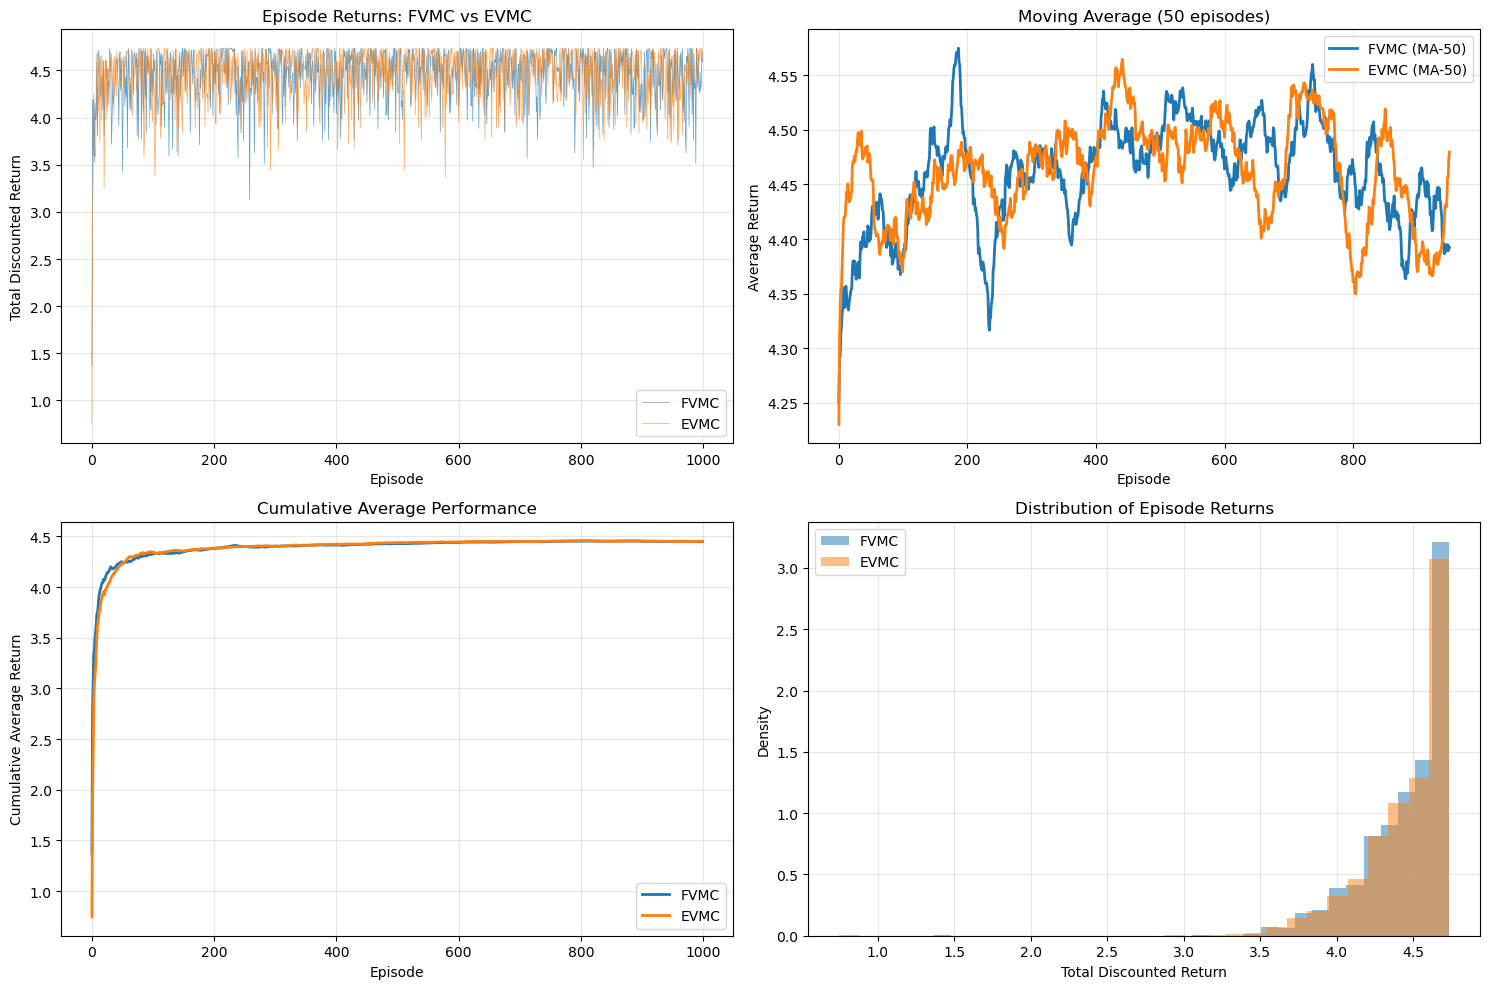

Statistical Comparison:

FVMC:
  Mean return: 4.45
  Std return:  0.29
  Final 100 episodes mean: 4.42

EVMC:
  Mean return: 4.45
  Std return:  0.30
  Final 100 episodes mean: 4.42


In [64]:
# Plotting comparison
plt.figure(figsize=(15, 10))

# Plot 1: Episode returns comparison
plt.subplot(2, 2, 1)
plt.plot(returns_fvmc, label='FVMC', alpha=0.7, linewidth=0.5)
plt.plot(returns_evmc, label='EVMC', alpha=0.7, linewidth=0.5)
plt.xlabel('Episode')
plt.ylabel('Total Discounted Return')
plt.title('Episode Returns: FVMC vs EVMC')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Moving average of returns
window = 50
plt.subplot(2, 2, 2)
fvmc_ma = np.convolve(returns_fvmc, np.ones(window)/window, mode='valid')
evmc_ma = np.convolve(returns_evmc, np.ones(window)/window, mode='valid')
plt.plot(fvmc_ma, label=f'FVMC (MA-{window})', linewidth=2)
plt.plot(evmc_ma, label=f'EVMC (MA-{window})', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Average Return')
plt.title(f'Moving Average ({window} episodes)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Cumulative average returns
plt.subplot(2, 2, 3)
cumulative_fvmc = np.cumsum(returns_fvmc) / (np.arange(len(returns_fvmc)) + 1)
cumulative_evmc = np.cumsum(returns_evmc) / (np.arange(len(returns_evmc)) + 1)
plt.plot(cumulative_fvmc, label='FVMC', linewidth=2)
plt.plot(cumulative_evmc, label='EVMC', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Cumulative Average Return')
plt.title('Cumulative Average Performance')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Distribution comparison
plt.subplot(2, 2, 4)
plt.hist(returns_fvmc, bins=30, alpha=0.5, label='FVMC', density=True)
plt.hist(returns_evmc, bins=30, alpha=0.5, label='EVMC', density=True)
plt.xlabel('Total Discounted Return')
plt.ylabel('Density')
plt.title('Distribution of Episode Returns')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison
print("Statistical Comparison:")
print(f"\nFVMC:")
print(f"  Mean return: {np.mean(returns_fvmc):.2f}")
print(f"  Std return:  {np.std(returns_fvmc):.2f}")
print(f"  Final 100 episodes mean: {np.mean(returns_fvmc[-100:]):.2f}")

print(f"\nEVMC:")
print(f"  Mean return: {np.mean(returns_evmc):.2f}")
print(f"  Std return:  {np.std(returns_evmc):.2f}")
print(f"  Final 100 episodes mean: {np.mean(returns_evmc[-100:]):.2f}")